In [2]:

from dataloader import *





In [3]:
class polypSegmentationDataset(Dataset):
    def __init__(self,root,img_dir,mask_dir,transform=None):
        self.root = root 
        super().__init__()
        self.image_dir = img_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted(os.listdir(img_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.transform = transform

        self.class_dict = {
            (0, 0, 0): 0,       
            (255, 255, 255): 1  
        }

    def __len__(self):
            return len(self.image_filenames)
        
    def mask_to_class(self, mask):
            mask = np.array(mask)
            class_mask = np.zeros(mask.shape[:2], dtype=np.uint8)

            for rgb, class_id in self.class_dict.items():
                matches = (mask == rgb).all(axis=-1)
                class_mask[matches] = class_id

            return class_mask
    
    def __getitem__(self,idx):
            img_path = os.path.join(self.image_dir,self.image_filenames[idx])
            mask_path = os.path.join(self.mask_dir,self.mask_filenames[idx])

            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
            mask = np.expand_dims(mask, axis=-1)    
            

            if self.transform:
                augmented = self.transform(image=image,mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            return image,mask   


In [4]:
dataset_demo = polypSegmentationDataset(root='Data',img_dir='Data/kvasir-seg/Kvasir-SEG/images',mask_dir='Data/kvasir-seg/Kvasir-SEG/masks',transform=None)
print(dataset_demo[2][0].shape,dataset_demo[2][1].shape)

(529, 619, 3) (529, 619, 1)


In [5]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.5),
    A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
    A.ToTensorV2(),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5)

])


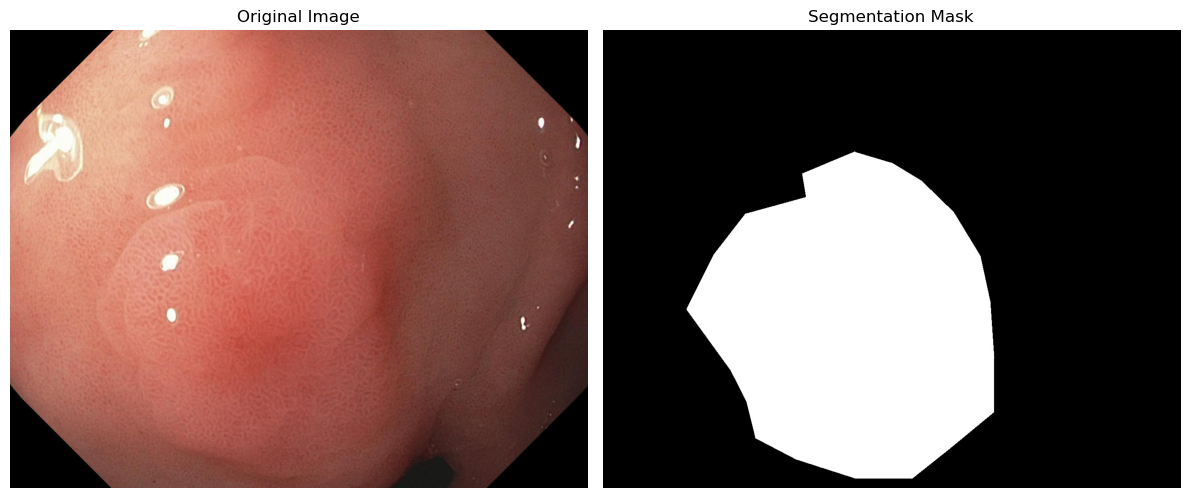

In [6]:


def load_image(image_path):
    return Image.open(image_path).convert("RGB")

def load_mask(mask_path):
    return Image.open(mask_path).convert("L")

def visualize_image_and_mask(image, mask):
    image_np = np.array(image)
    mask_np = np.array(mask)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

image_dir = 'Data/kvasir-seg/Kvasir-SEG/images'
mask_dir = 'Data/kvasir-seg/Kvasir-SEG/masks'
image_filename = 'cju0qoxqj9q6s0835b43399p4.jpg'
mask_filename = 'cju0qoxqj9q6s0835b43399p4.jpg'

image_path = os.path.join(image_dir, image_filename)
mask_path = os.path.join(mask_dir, mask_filename)

image = load_image(image_path)
mask = load_mask(mask_path)

visualize_image_and_mask(image, mask)


In [7]:
class ConvBlock(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(ConvBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel,out_channel,3,padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x

In [8]:
    
class Up(nn.Module):
    def __init__(self,in_channel,out_channel,bilinear = True):
        super(Up,self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)#Bilinear interpolation
        else:
            self.up = nn.ConvTranspose2d(in_channel//2,in_channel//2,2,stride=2)
        self.conv = ConvBlock(in_channel,out_channel)

    def forward(self,x1,x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x




In [9]:

class AttentionBlock(nn.Module):
    def __init__(self,fg,fl,n_coefficients):
        super(AttentionBlock,self).__init__()

        self.wgate = nn.Sequential(
            nn.Conv2d(fg,n_coefficients,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.wx = nn.Sequential(
            nn.Conv2d(fl,n_coefficients,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients,1,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,gate,skip):
        g1 = self.wgate(gate)
        x1 = self.wx(skip)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        out = skip*psi 
        return out 



In [10]:

class AttentionUnet(nn.Module):
    def __init__(self, img_ch=3,out_ch=1):
        super(AttentionUnet,self).__init__()
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv1 = ConvBlock(in_channel=img_ch,out_channel=64)
        self.conv2 = ConvBlock(in_channel=64,out_channel=128)
        self.conv3 = ConvBlock(in_channel=128,out_channel=256)
        self.conv4 = ConvBlock(in_channel=256,out_channel=512)
        self.conv5 = ConvBlock(in_channel=512,out_channel=1024)

        self.up5 = Up(in_channel=1024,out_channel=512,bilinear=False)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.upconv5 = ConvBlock(in_channel=1024,out_channel=512)

        self.Up4 = Up(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)


        self.Up3 = Up(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)


        self.Up2 = Up(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, out_ch, kernel_size=1, stride=1, padding=0)

        def forward(self,x):

            enc1 = self.conv1(x)
            enc2= self.Maxpool(enc1)
            enc2 = self.conv2(enc2)
            enc3 = self.Maxpool(enc2)
            enc3 = self.conv3(enc3)
            enc4 = self.Maxpool(enc3)
            enc4 = self.conv4(enc4)
            enc5 = self.Maxpool(enc4)
            enc5 = self.conv5(enc5)

            dec5 = self.up5(enc5)
            at5 = self.Att5(dec5,enc4)
            dec5 = torch.cat((at5,dec5),dim=1)
            dec5 = self.upconv4(dec5)


            dec4 = self.Up4(dec5)   
            at4 = self.Att4(dec4,enc3)
            dec4 = torch.cat((at4,dec4),dim=1)
            dec4 = self.UpConv4(dec4)

            dec3 = self.Up3(dec4)
            at3 = self.Att3(dec3,enc2)
            dec3 = torch.cat((at3,dec3),dim=1)
            dec3 = self.UpConv3(dec3)

            dec2 = self.up2(dec3)
            at2 = self.Att2(dec2,enc1)
            dec2 = torch.cat((at2,dec2),dim=1)
            dec2 = self.UpConv2(dec2)

            out = self.conv(dec2)

            return out 
        


    

In [ ]:
class DICE_BCE_Loss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        intersection = 2*(logits * targets).sum() + self.smooth
        union = (logits + targets).sum() + self.smooth
        dice_loss = 1. - intersection / union

        loss = nn.BCELoss() 
        bce_loss = loss(logits, targets)

        return dice_loss + bce_loss
    
def dice_coeff(logits, targets):
    intersection = 2*(logits * targets).sum()
    union = (logits + targets).sum()
    if union == 0:
        return 1
    dice_coeff = intersection / union
    return dice_coeff.item()



def compute_iou(outputs, targets, threshold=0.5, smooth=1e-6):
    
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()
